The goal of this notebook is to show how synthetic market data is generated using the following methods:
- `generate_random_price_data` (for one and multiple assets)
- `generate_random_bars`
- `get_gaussian_walk`

## Imports

In [1]:
import logging

import matplotlib.pyplot as plt
import pandas as pd

import core.artificial_signal_generators as carsigen
import core.finance as cofinanc
import core.finance.market_data_example as cfmadaex
import dataflow.core as dtfcore
import dataflow.system as dtfsys
import dataflow.core.utils as dtfcorutil
import helpers.hdbg as hdbg
import helpers.hprint as hprint

/app/amp/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-18d42e39-e6c3-4c31-b662-bb2d5aecf3d8.json'


# Generate the data

## Using `generate_random_price_data` for multiple assets

Problems:
- Generated prices are the same for all assets
- Distribution of returns is not normal

In [3]:
# Generate the initial price data.
start_datetime = pd.Timestamp("2021-01-01")
end_datetime = pd.Timestamp("2021-01-31")
columns = ["close"]
asset_ids = list(range(2))
freq = "1T"
initial_price = 29000
seed = (100,)

df = cfmadaex.generate_random_price_data(
    start_datetime,
    end_datetime,
    columns,
    asset_ids,
    freq=freq,
    initial_price=initial_price,
    seed=seed,
)

df = df.set_index("timestamp_db").drop(columns=["start_datetime", "end_datetime"])
df = dtfcorutil.convert_to_multiindex(df, "asset_id")

In [4]:
# Calculate returns.
node_returns_config = {
    "in_col_groups": [
        ("close",),
    ],
    "out_col_group": (),
    "transformer_kwargs": {
        "mode": "pct_change",
    },
    "col_mapping": {
        "close": "close.ret_0",
    },
}
# Create the node that computes ret_0.
nid = "ret0"
node = dtfcore.GroupedColDfToDfTransformer(
    nid,
    transformer_func=cofinanc.compute_ret_0,
    **node_returns_config,
)
# Compute the node on the data.
rets = node.fit(df)

In [5]:
# Show DataFrame with prices and returns for multiple assets.
df = rets["df_out"]
df.head(5)

close.ret_0                   close              
                              0         1             0             1
timestamp_db                                                         
2021-01-01 00:01:00         NaN       NaN  28999.645669  28999.645669
2021-01-01 00:02:00   -0.000002 -0.000002  28999.600596  28999.600596
2021-01-01 00:03:00    0.000009  0.000009  28999.871380  28999.871380
2021-01-01 00:04:00    0.000007  0.000007  29000.076893  29000.076893
2021-01-01 00:05:00    0.000008  0.000008  29000.308852  29000.308852

<AxesSubplot: xlabel='timestamp_db'>

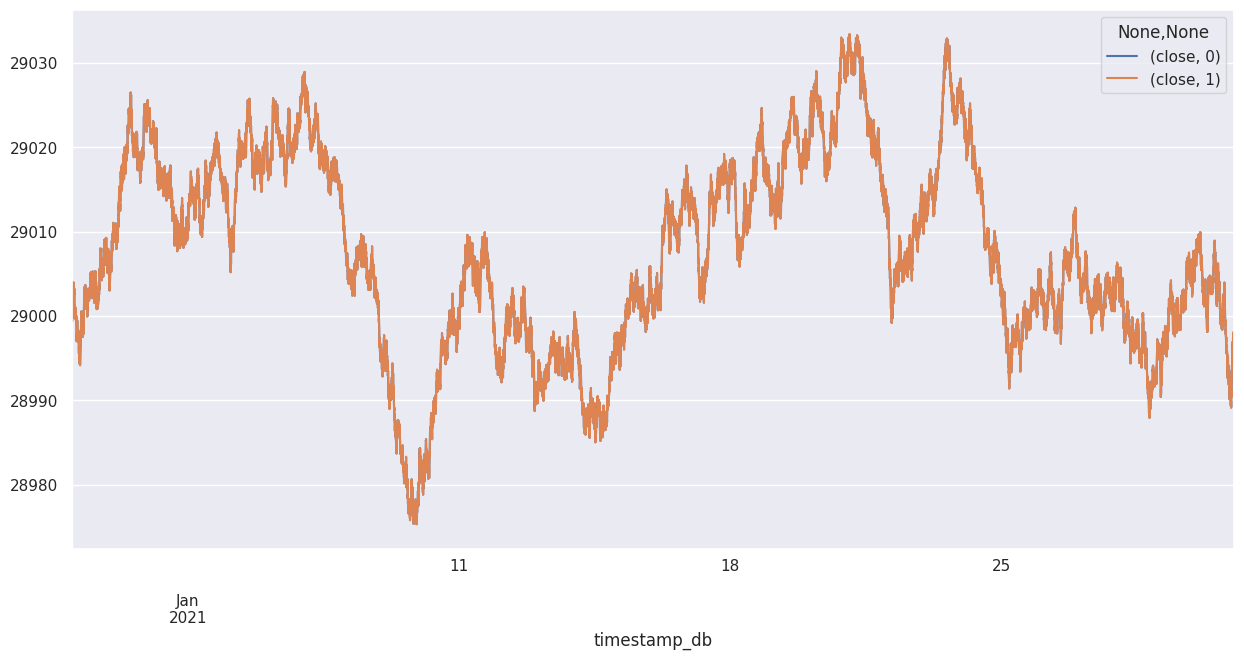

In [6]:
# Plot the prices.
df[["close"]].plot(figsize=(15, 7))

<AxesSubplot: xlabel='timestamp_db'>

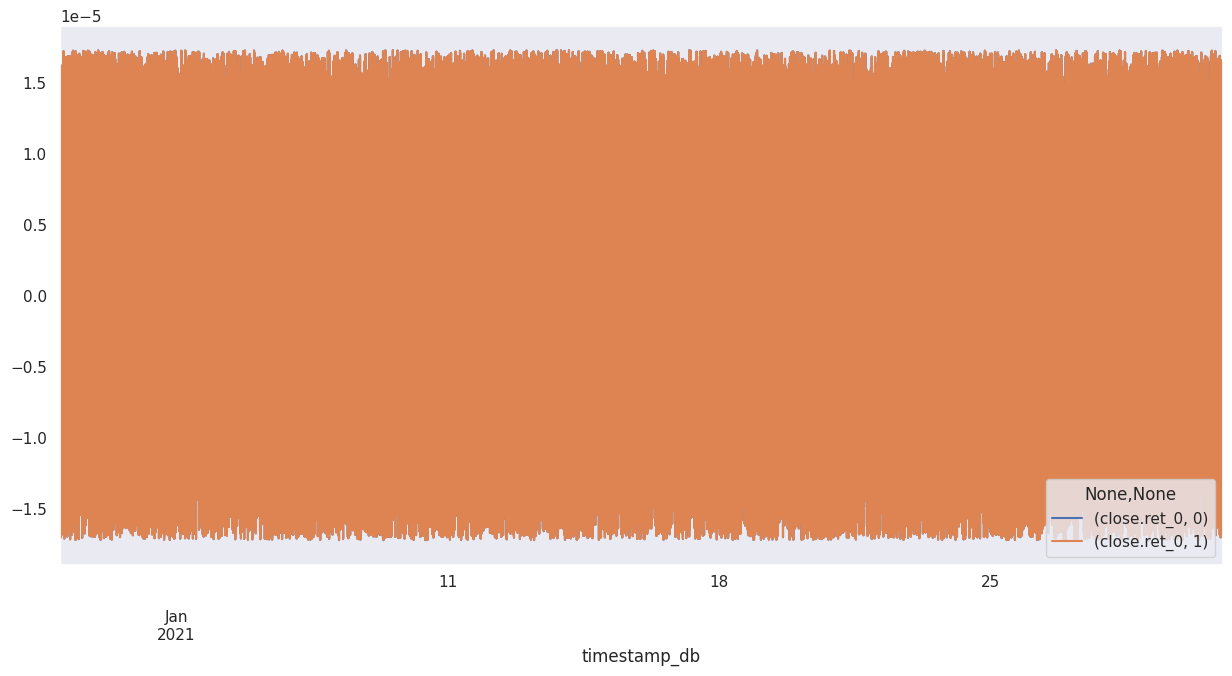

In [7]:
# Plot returns.
df[["close.ret_0"]].plot(figsize=(15, 7))

## Using `generate_random_price_data` for one asset


Problems:
- Distribution of returns is not normal

In [8]:
start_datetime = pd.Timestamp("2021-01-01")
end_datetime = pd.Timestamp("2021-01-31")
columns = ["close"]
asset_ids = [1]
freq = "1T"
initial_price = 29000
seed = (100,)

df = cfmadaex.generate_random_price_data(
    start_datetime,
    end_datetime,
    columns,
    asset_ids,
    freq=freq,
    initial_price=initial_price,
    seed=seed,
)

df = df.set_index("timestamp_db").drop(
    columns=["start_datetime", "end_datetime", "asset_id"]
)
df["rets"] = cofinanc.compute_ret_0(df[["close"]], "pct_change")
df.head(3)

,close,rets
timestamp_db,,
2021-01-01 00:01:00,28999.645669,NaN
2021-01-01 00:02:00,28999.600596,-0.000002
2021-01-01 00:03:00,28999.871380,0.000009


<AxesSubplot: xlabel='timestamp_db'>

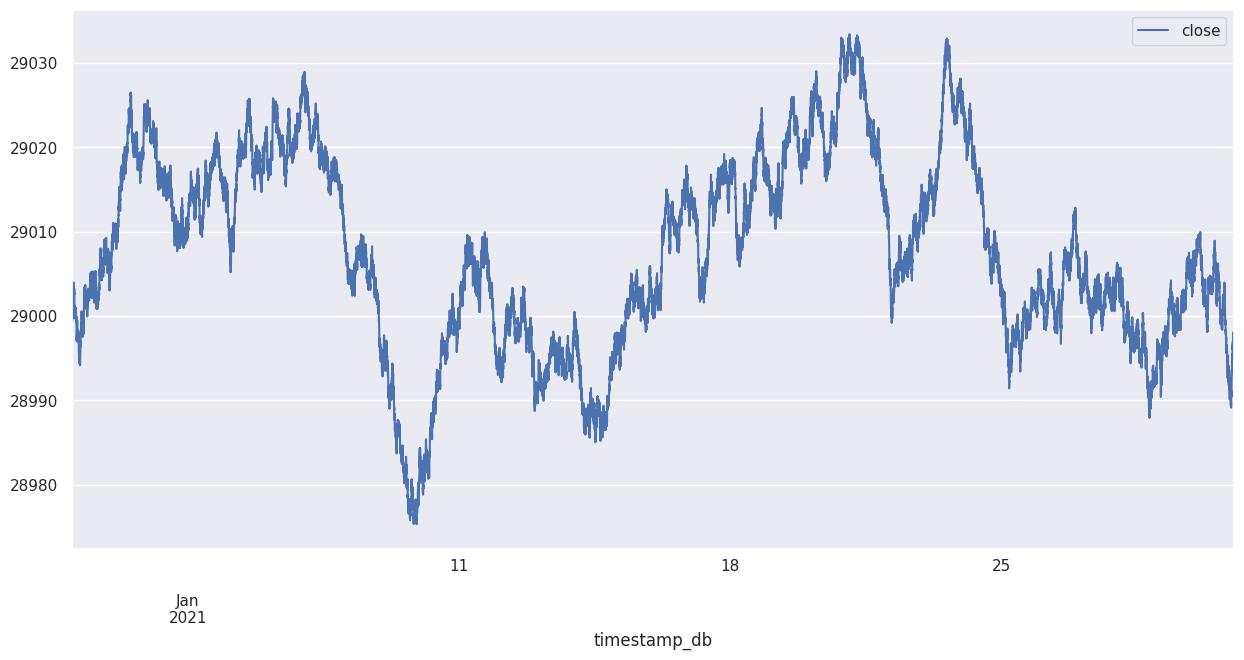

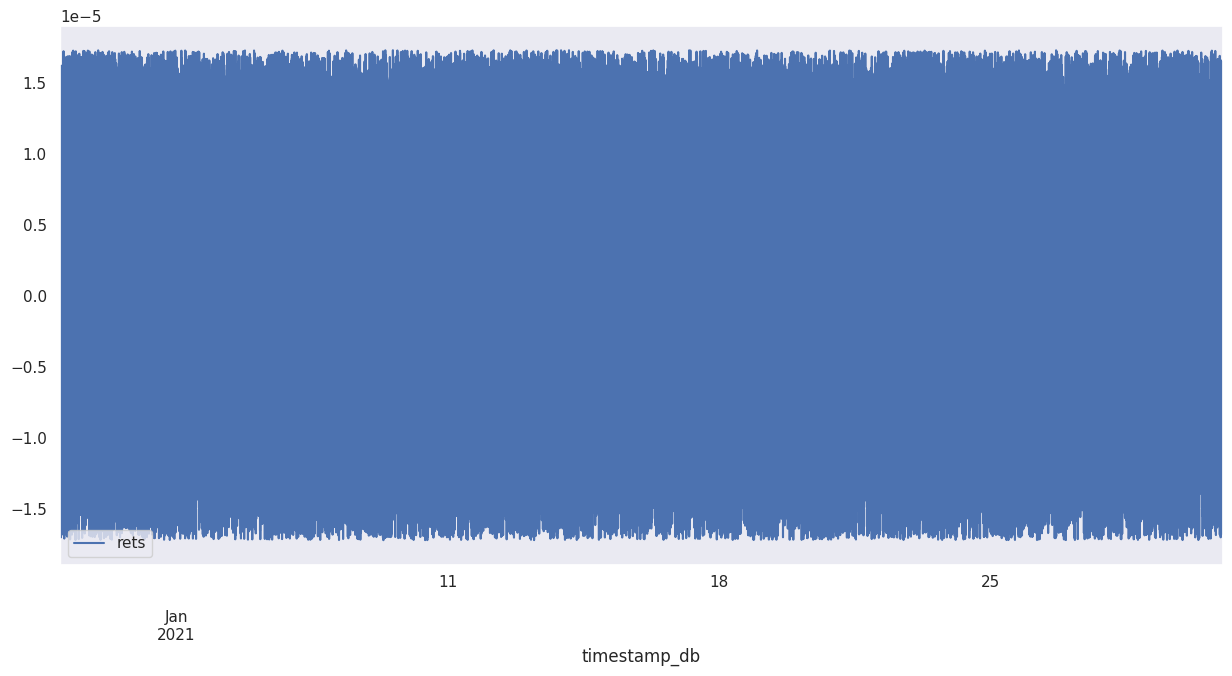

In [9]:
df[["close"]].plot(figsize=(15, 7))
df[["rets"]].plot(figsize=(15, 7))

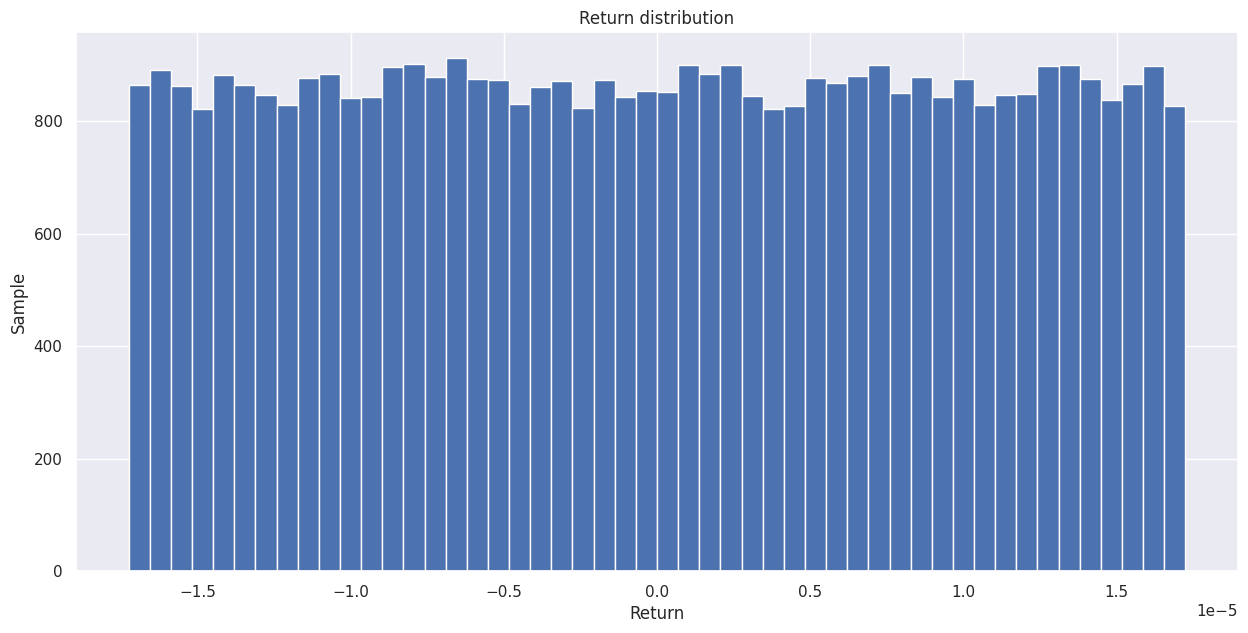

In [10]:
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
df["rets"].hist(bins=50, ax=ax1)
ax1.set_xlabel("Return")
ax1.set_ylabel("Sample")
ax1.set_title("Return distribution")
plt.show()

## Using `generate_random_bars`


Problems:
- Strange outcomes

In [11]:
# Generate the data.
start_datetime = pd.Timestamp("2021-01-01")
end_datetime = pd.Timestamp("2021-01-31")

df = cfmadaex.generate_random_bars(
    start_datetime,
    end_datetime,
    asset_ids=[1, 2],
)

df = df.set_index("timestamp_db").drop(columns=["start_datetime", "end_datetime"])
df = dtfcorutil.convert_to_multiindex(df, "asset_id")

<AxesSubplot: xlabel='timestamp_db'>

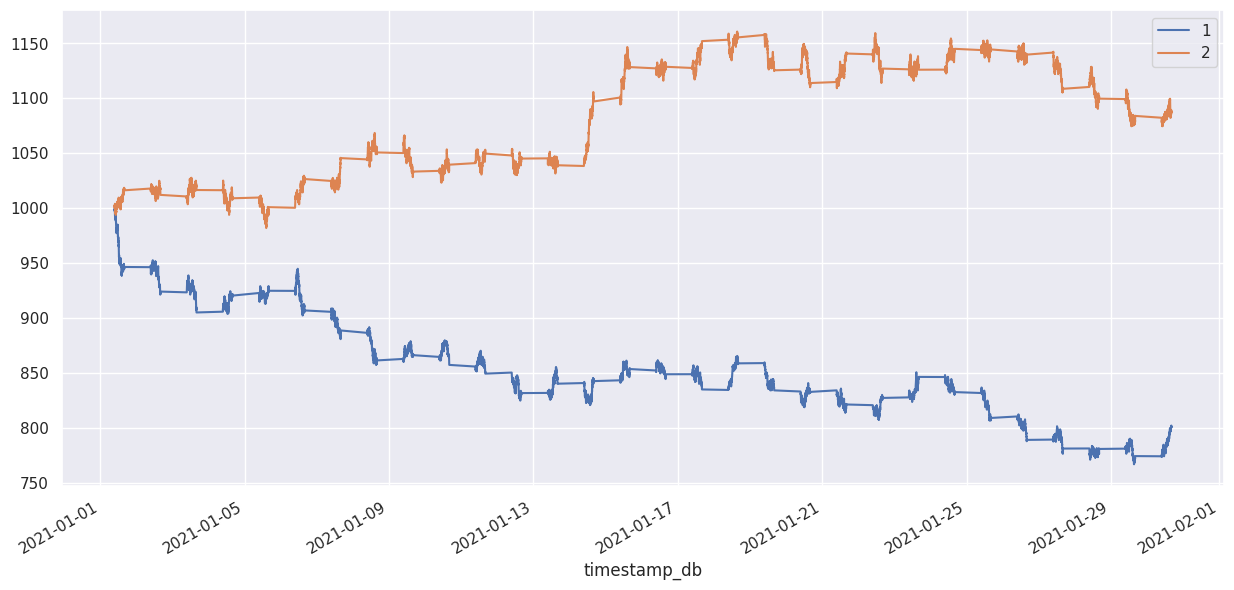

In [12]:
# Show prices.
df["close"].plot(figsize=(15, 7))

In [13]:
# Calculate returns.
node_returns_config = {
    "in_col_groups": [
        ("close",),
    ],
    "out_col_group": (),
    "transformer_kwargs": {
        "mode": "pct_change",
    },
    "col_mapping": {
        "close": "close.ret_0",
    },
}
# Create the node that computes ret_0.
nid = "ret0"
node = dtfcore.GroupedColDfToDfTransformer(
    nid,
    transformer_func=cofinanc.compute_ret_0,
    **node_returns_config,
)
# Compute the node on the data.
rets = node.fit(df)
rets["df_out"].head(3)

close.ret_0                 close                 f1          f2          s1          s2      volume     
                              1         2           1            2     1     2     1     2     1      2    1    2      1    2
timestamp_db                                                                                                                 
2021-01-01 09:31:10         NaN       NaN  998.897270  1000.034193  1954  2037  2066  1949  0.98   1.96   98   98   1017  939
2021-01-01 09:32:10   -0.000725  0.001361  998.173307  1001.394912  2043  2017  1977  2032  2.72   5.92   87   99   1036  988
2021-01-01 09:33:10   -0.000781  0.001225  997.393235  1002.622093  2067  2031  2057  1949  5.75  11.37  101  109    995  984

<AxesSubplot: xlabel='timestamp_db'>

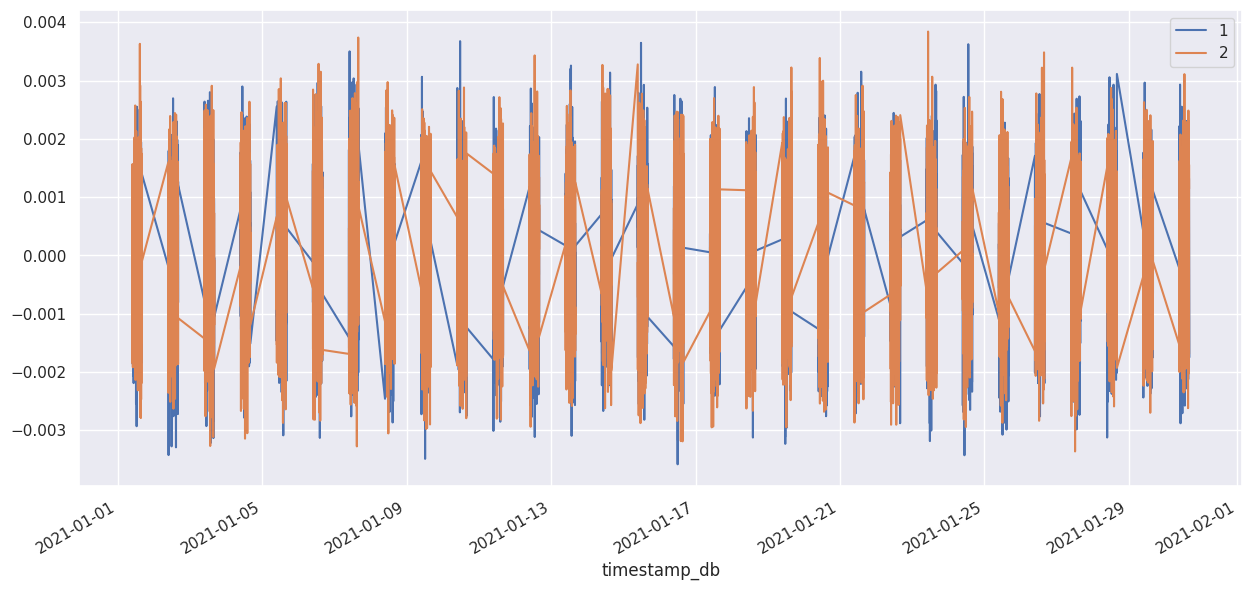

In [14]:
# Show returns.
rets["df_out"]["close.ret_0"].plot(figsize=(15, 7))

## Using returns directly (`get_gaussian_walk`)

In [15]:
drift = 0
vol = 0.2
size = 252
seed = 10
rets = carsigen.get_gaussian_walk(drift, vol, size, seed=seed).diff()

<AxesSubplot: >

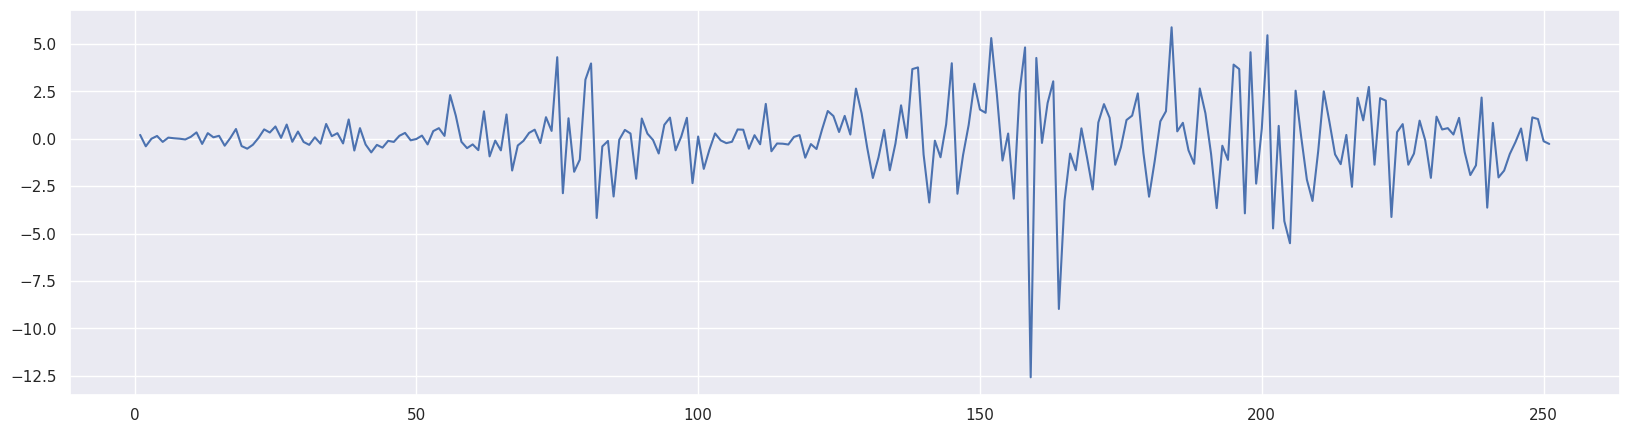

In [16]:
rets.plot()

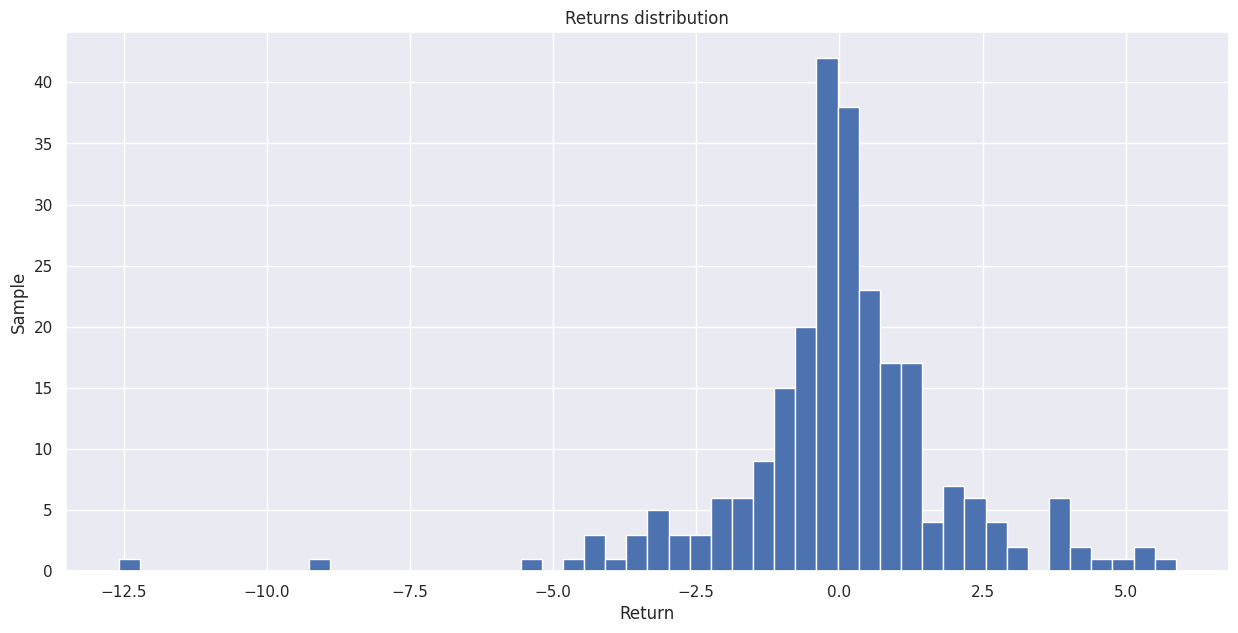

In [17]:
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 1, 1)
rets.hist(bins=50, ax=ax1)
ax1.set_xlabel("Return")
ax1.set_ylabel("Sample")
ax1.set_title("Returns distribution")
plt.show()